In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.rc('figure', figsize=(20, 6))

IRIS = load_iris()
iris_df = pd.DataFrame(IRIS.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
labels = IRIS.target_names

## The Bias-Variance Tradeoff

In his [1996 paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.390.9412&rep=rep1&type=pdf), "The Lack of A Priori Distinctions between Learning Algorithms," David Wolpert asserts that "There is No Free Lunch in Machine Learning", essentially saying that the performance of on machine learning models are equivalent when averaged across all possible problems. In other words, there is no way to know which model is going to perform at best for a particular problem. In practice this means that we must have strong methods for assessing the performance of our models.

Thinking about model performance is complex. We cannot simply choose the model that performs best with the data that we have. The reason for this is that the data we have represents a sample of the actual data that we could possibly collect now or in the future. The "best model" is not necessarily one that performs best on the data that we have. The best model is a model that performs extremely well on the data that we have but it's also capable of generalizing to new data. In statistical learning, we have a framework for thinking about this called The Bias-Variance Tradeoff.


This framework is difficult to understand. Adding to the difficulty is the fact that both "bias" and "variance" are important concepts for working in applied statistics **and** the meaning of these terms is difficult to reconcile with their meaning when thinking about the Bias-Variance Tradeoff.

Let us try to come to a high level understanding of these terms in this setting before looking at them in application. You might think of **bias** as the extent to which a particular model can learn to represent an underlying physical phenomenon. A low bias means that the model was able to learn the phenomenon well. For example, looking at the Iris data set, if we are building a regression model to predict the petal width then bias would be the degree to which our model was able to learn the relationship between petal length and petal width or sepal width and petal width. 

**Variance** on the other hand is the extent to which a particular model would change if fit with different data. We previously looked at sampling our data set. We saw the measured means of value change with each sample. From this we can infer that a model predicting the meaning with only a few points of data has a high variance.

#### The Gory Details

If we have split our data into a training set and a testing set, then we can think of choosing the best model in terms of optimizing the expected test error, $MSE_{test}$

Let's consider sources of possible test error:

$$MSE_{test} = \mathbb{E}\left[(y-\widehat{y})^2\right] = \text{Var}\left(\widehat{y}\right) + \left(\text{Bias}\left(\widehat{y}\right)\right)^2 + \text{Var}\left(\epsilon\right)$$

This is intended to be a conceptual and not an actual calculation to be performed. Let's think about what each of these terms might represent. The variance is error introduced to the model by the specific choice of training data. Of course this isn't something that we choose, at least not with out using randomness, but the training data that is used will impact the model. By nature, variance is a squared value and that's always positive. Bias is introduced by choosing a specific model. Note that it is squared here and thus also always positive. The last term is the variance caused by noise in the system. We have no way of controlling this, nor of actually knowing what is truly noise and what is model variance or bias. Again this term is always positive.

The important thing is that all three of these terms are always positive. The impact of this is that one kind of error cannot be offset by another kind of error. A high variance cannot be offset by a low bias. **In order to choose the best model, we are going to need to simultaneously minimize both bias and variance.** The problem is changing an aspect of our model to decrease one Will typically increase the other -- The Bias-Variance Tradeoff.

### Model Assessment

Consider these eight models for predicting petal width $x_{pw}$ on the Iris data set, using the other three features, petal length $x_{pl}$, sepal length $x_{sl}$, and sepal width $x_{sw}$

\begin{align*}
\widehat{f}_0 = \widehat{x}_{pw} &= \beta_0 \\
\widehat{f}_1 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{pl}\\
\widehat{f}_2 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{sl}\\
\widehat{f}_3 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{sw}\\
\widehat{f}_4 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{pl} + \beta_1x_{sl}\\
\widehat{f}_5 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{pl} + \beta_1x_{sw}\\
\widehat{f}_6 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{sl} + \beta_1x_{sw}\\
\widehat{f}_7 = \widehat{x}_{pw} &= \beta_0 + \beta_1x_{pl} + \beta_1x_{sl}+ \beta_1x_{sw}\\
\end{align*}

We will split our dataset into ten randomly chosen subsets of 50 points each. We will assess the performance of each of these models. We will use the mean of the performance to represent bias and the standard deviation of the performance to represent variance.

In [2]:
samples = []
for _ in range(10):
    samples.append(iris_df.sample(50))

In [22]:
[len(sample_set) for sample_set in samples]

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [3]:
from patsy import dmatrices

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [7]:
a = np.array((1,2,3))
b = np.array((4,5,6))

(b - a)**2

array([9, 9, 9])

In [8]:
def MSE(actual, predicted):
    return sum((actual - predicted)**2)/len(actual)

In [9]:
def test_func(model_description):
    
    test = dict()
    
    test['samples'] = [dmatrices(model_description, sample) for sample in samples]
    test['models']  = [LinearRegression(fit_intercept=False) for _ in range(10)]
    test['scores']  = []
    
    for model, sample in zip(test['models'], test['samples']):
        target = sample[0]
        features = sample[1]
        model.fit(features, target)
        test['scores'].append(MSE(model.predict(features), target))
    
    test['scores'] = np.array(test['scores'])
    results = { 'description' : model_description }
    results['bias'] = test['scores'].mean()
    results['variance'] = test['scores'].std()
    return test, results

In [11]:
test_1, results_1 = test_func("petal_width ~ 1")

In [20]:
test_1['scores']

array([[ 0.507156],
       [ 0.570804],
       [ 0.568756],
       [ 0.599636],
       [ 0.5084  ],
       [ 0.590096],
       [ 0.617524],
       [ 0.589456],
       [ 0.640896],
       [ 0.530544]])

In [19]:
test_1['scores'].mean(), test_1['scores'].std()

(0.5723267999999998, 0.042654670648828129)

In [13]:
results_1

{'description': 'petal_width ~ 1',
 'bias': 0.5723267999999998,
 'variance': 0.042654670648828129}

In [23]:
test_2, results_2 = test_func("petal_width ~ 1 + petal_length")
test_3, results_3 = test_func("petal_width ~ 1 + sepal_length")
test_4, results_4 = test_func("petal_width ~ 1 + sepal_width")
test_5, results_5 = test_func("petal_width ~ 1 + petal_length + sepal_width")
test_6, results_6 = test_func("petal_width ~ 1 + petal_length + sepal_length")
test_7, results_7 = test_func("petal_width ~ 1 + sepal_length + sepal_width")
test_8, results_8 = test_func("petal_width ~ 1 + petal_length + sepal_length + sepal_width")
results = [
    results_1,
    results_2,
    results_3,
    results_4,
    results_5,
    results_6,
    results_7,
    results_8
]

In [24]:
results = pd.DataFrame(results)

In [25]:
results['color'] = ['red','orange', 'yellow','green','blue','cyan','purple' ,'black']
results

,bias,description,variance,color
0,0.572327,petal_width ~ 1,0.042655,red
1,0.043182,petal_width ~ 1 + petal_length,0.005080,orange
2,0.205130,petal_width ~ 1 + sepal_length,0.028695,yellow
3,0.484729,petal_width ~ 1 + sepal_width,0.067398,green
4,0.040384,petal_width ~ 1 + petal_length + sepal_width,0.005210,blue
5,0.041526,petal_width ~ 1 + petal_length + sepal_length,0.004518,cyan
6,0.153357,petal_width ~ 1 + sepal_length + sepal_width,0.028932,purple
7,0.035012,petal_width ~ 1 + petal_length + sepal_length ...,0.003228,black


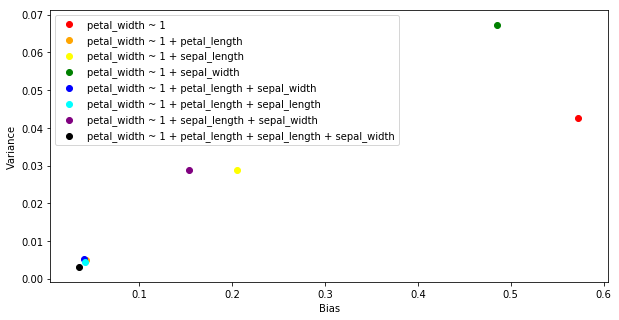

In [26]:
plt.figure(figsize=(10,5))
for i in results.index:
    plt.scatter(results.loc[i].bias, results.loc[i].variance, c=results.loc[i].color, label=results.loc[i].description)
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.legend()